In [2]:
import sys
import time
import datetime
from train import *
from params import TrainingParams
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

from params import TransferParams
from pipeline import *
import numpy as np

Using TensorFlow backend.


In [3]:
params = TrainingParams()
# params.train_path='/home/ubuntu/work/data/unlabeled2017/*.jpg'
params.train_path='data/train/val2017/*.jpg'
params.style_path='data/starry_night.jpg'
params.batch_size = 1
params.num_epoch = 1
params.learn_rate = 0.0001
params.total_train_sample = 128
params.style_weight = 2.5
params.tv_weight=0.0

In [4]:
def time_remaining(params, batch, epoch):
    time_remaining = 0
    if params.last_time is None:
        params.last_time = time.perf_counter()
    else:
        total_epoch = params.num_epoch
        if params.restore_epoch is not None:
            total_epoch += params.restore_epoch + 1
        cur_time = time.perf_counter()
        elapsed = cur_time - params.last_time
        params.last_time = cur_time
        batches_per_epoch = (params.total_train_sample/params.batch_size)
        batch_remaining = batches_per_epoch*(total_epoch-epoch) - batch
        time_remaining = int(batch_remaining*elapsed)
    return time_remaining

In [5]:
def keep_last(data, entry):
#     if len(data) > 20:
#         data = data[1:]
    data.append(entry)
    return data

In [9]:
def report_loss(params, batch, epoch, total_cost, content_cost, style_cost):
    params.cost_history = keep_last(params.cost_history, total_cost)
    params.style_history = keep_last(params.style_history, style_cost)
    params.content_history =keep_last(params.content_history, content_cost)
#     t = time_remaining(params, batch, epoch)
#     plt.title("Batch %i of epoch %i. Total Loss: %s. ETA %s " % (batch, epoch, str(total_cost), str(datetime.timedelta(seconds=t))))
    plt.plot(params.cost_history, 'r', params.style_history, 'b', params.content_history, 'g')
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [7]:
def report_loss_simple(params, batch, epoch, total_cost, content_cost, style_cost):
    t = time_remaining(params, batch, epoch)
    sys.stdout.write("\r")
    sys.stdout.write("Batch %i of epoch %i. Total Loss: %s. ETA %s " % (batch, epoch, str(total_cost), str(datetime.timedelta(seconds=t))))
    sys.stdout.flush()

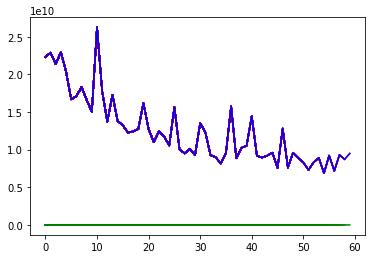

In [ ]:
params.cost_history = []
params.style_history = []
params.content_history = []
params.last_time = None
params.restore_epoch = None
train(params, report_fn=report_loss, restore_epoch=params.restore_epoch)

In [ ]:
def transfer(path, out_path=None):
    # init    
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    input_image = process_img(path).eval()
    input_shape = [1] + list(input_image.shape)
    
    # make the model
    input_placeholder = tf.placeholder(dtype=tf.float32, shape=input_shape, name='input_images')
    gen = SpriteGenerator(input_placeholder, 'SpriteGenerator')
    
    # restore
    saver = tf.train.Saver()
    saver.restore(sess, 'data/model/style.ckpt')
    
    # generate and write out
    output = sess.run(gen.output, feed_dict={input_placeholder:np.stack([input_image])})
    plt.imshow(output[0]/255.)  
    
    if out_path is not None:
        output = tf.image.encode_jpeg(output[0])  
        write = tf.write_file(out_path, output)
        sess.run(write)
        print('Generate Done.')

In [ ]:
# transfer('data/test.jpg', 'data/generated.jpg')

In [ ]:
def do():
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    input_shape = [2,256,256,3]
    input_placeholder = tf.placeholder(dtype=tf.float32, shape=input_shape, name='input_images')
    input_style = np.zeros([2,256,256,3])
    params = TrainingParams()

    gen = SpriteGenerator(input_placeholder, 'SpriteGenerator')
    vggTrain = VGG16(gen.output, 'train_vgg')
    vggRef = VGG16(input_placeholder, 'train_ref')

    J = total_loss(sess, input_placeholder, gen, vggTrain, vggRef, input_style, params)
    
    for t in tf.trainable_variables():
        print(t)